In [12]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s
from pycausal.pycausal import pycausal as pc
from collections import defaultdict
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text
from pycausal import prior as p
import itertools

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="0" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))
    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=False)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=False)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model



def get_bic(df, prior, penalty = 2):

    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True, penalty = 200
              )

    
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)

def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))
def make_categorical(df, complete_df, categoricals):   
    retval = None
    for key in df.columns:
        if retval is not None:
            if key in categoricals:
                retval = np.concatenate((retval, to_categorical(df[key], len(complete_df[key].unique()))), axis = 1)
            else:
                retval = np.concatenate((retval, df[key].values[...,np.newaxis]), axis = 1)
        else:
            if key in categoricals:
                retval = to_categorical(df[key], len(complete_df[key].unique()))
            else:
                retval = df[key]
    return retval
num_models = 100
pc = pc()
pc.start_vm(java_max_heap_size = '21000M')
tetrad = s.tetradrunner()

models = []
model_names = []



randomize = False
if randomize:
    layers = [256, 512, 1024, 2048, 4096]
    for i in range(num_models):
        network = []
        for j in range(3):
            network.append(layers[random.randint(0,len(layers) -1)])
        models.append(network)
        model_names.append('temp/4sim' + str(i))
    print(models, model_names)    
else:
    model_layers = [512, 256]
    for i in range(num_models):
        models.append(model_layers)
        model_names.append('temp/4sim' + str(i))

print(models, model_names)

[[512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [51

In [2]:
import pydot
from IPython.display import SVG

def examine_graph_continuous(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               )
    return tetrad.getTetradGraph()

def gen_data(list_vertex = [], list_edges = [], mean = 0, var = 1, SIZE = 20000, perturb = []):
    g = []
    for v in list_vertex:
        if v in perturb:
            g.append(np.random.normal(mean,var,SIZE))
            print("perturbing ", v, "with meanm var = ", mean, var)
        else:
            g.append(np.random.normal(0,1,SIZE))
        
    for edge in list_edges:
        g[edge[1]] += g[edge[0]]
    g = np.swapaxes(g,0,1)
    return pd.DataFrame(g, columns = list(map(str, list_vertex)))

import networkx as nx

def random_dag(nodes, edges):
    """Generate a random Directed Acyclic Graph (DAG) with a given number of nodes and edges."""
    G = nx.DiGraph()
    for i in range(nodes):
        G.add_node(i)
    while edges > 0:
        a = random.randint(0,nodes-1)
        b=a
        while b==a:
            b = random.randint(0,nodes-1)
        G.add_edge(a,b)
        if nx.is_directed_acyclic_graph(G):
            edges -= 1
        else:
            # we closed a loop!
            G.remove_edge(a,b)
    return G




In [3]:

bestMSE = []
bestBIC = []
bestCOMBO = []
bestWRONG = []
bestPOSSIBLE= []
worstMSE = []
worstBIC = []
worstCOMBO = []
worstWRONG = []
worstPOSSIBLE= []

qbestMSE = []
qbestBIC = []
qbestCOMBO = []
qbestWRONG = []
qbestPOSSIBLE= []
qworstMSE = []
qworstBIC = []
qworstCOMBO = []
qworstWRONG = []
qworstPOSSIBLE= []


sbestMSE = []
sbestBIC = []
sbestCOMBO = []
sbestWRONG = []
sbestPOSSIBLE= []
sworstMSE = []
sworstBIC = []
sworstCOMBO = []
sworstWRONG = []
sworstPOSSIBLE= []

sqbestMSE = []
sqbestBIC = []
sqbestCOMBO = []
sqbestWRONG = []
sqbestPOSSIBLE= []
sqworstMSE = []
sqworstBIC = []
sqworstCOMBO = []
sqworstWRONG = []
sqworstPOSSIBLE= []

averageDegree = []
targetDegree = []
target_inD = []
target_outD = []
descendants = []
graphDiff = []

In [9]:

t= 0
while (t < 50):
    train_size = 10000
    nodes = 4
    test_mean = random.uniform(0.1, 1.0)
    test_var = random.uniform(1.1, 2.0)
    test_size = 2000
    
    
    w_G = random_dag(nodes, random.randint(nodes, nodes*nodes)) # since max number of edges is n^2
    require = []
    for i in w_G.edges:
        require.append([str(i[0]), str(i[1])])  
    w_prior = p.knowledge(requiredirect = require)

    
    G = random_dag(nodes, random.randint(nodes - 1, 2*nodes)) # since max number of edges is n^2
    df = gen_data(np.arange(nodes), G.edges, SIZE = train_size)
    require = []
    for i in G.edges:
        require.append([str(i[0]), str(i[1])])  
    prior = p.knowledge(requiredirect = require)
    examine_graph_continuous(df, prior)
    
    
    
    # Check to make sure that graph matches our prior knowledge. Or else abort this test.
    a = set()
    for i in tetrad.getEdges():
        a.add((i[0], i[-1]))
    b = set()
    for i in require:
        b.add((i[0], i[1]))
    print("A = ", a)
    print("B = ", b)
    if a != b:
        continue

        
    # Need to set our inputs and outputs
    inputs = set(np.arange(nodes))
    #target = str(a.pop()[random.randint(0,1)])
    target = str([x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)>=1][0])
    inputs.remove(int(target))
    inputs = list(map(str, inputs))
    
    #perturb = random.randint(0,nodes - 1)
    perturb = int(inputs[random.randint(0,nodes - 2)])
    df_test = gen_data(np.arange(nodes), G.edges, mean = test_mean, var = test_var, SIZE = test_size, perturb = [perturb])
    sdf_test = gen_data(np.arange(nodes), G.edges, mean = random.uniform(0.01, 0.1), var = random.uniform(1.01, 1.1), SIZE = test_size, perturb = [perturb])
    target = [target]
    
    print("Inputs = ", inputs)
    print("Target = ", target)
    
    x_test = df_test[inputs]
    y_test = df_test[target]
    
    sx_test = sdf_test[inputs]
    sy_test = sdf_test[target]

    causal_split = 0.2
    val_split = 0.2
    train_split = 1 - (causal_split + val_split)

    x_causal = df[inputs][-int(causal_split * len(df)) :]
    y_causal = df[target][-int(causal_split * len(df)) :]

    x_val = df[inputs][int(train_split * len(df)):-int(causal_split * len(df))]
    y_val = df[target][int(train_split * len(df)):-int(causal_split * len(df))]

    x_train = df[inputs][:int(train_split * len(df))]
    y_train = df[target][:int(train_split * len(df))]

    verbosity = 0

    for idx, model_name in enumerate(model_names):
        if idx % 10 == 0:
            print(idx)
        if type(models[idx]) is list:
            #clear session
            keras.backend.clear_session() 
            #get model according to specification
            model = get_model(models[idx], [0.4] * len(models), np.shape(x_train)[1])
            callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                         EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
            model.compile(optimizer = optimizers.SGD(lr = 0.0001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
            #print(len(X), len(y))
            model.fit(x_train, y_train, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
        else:
            models[idx].fit(X,y)





    generalization = []
    metrics = []
    proposed = []
    w_proposed = []
    x_causal.reset_index(drop=True, inplace = True)
    for idx, model_name in enumerate(model_names):
        #print(model_name)
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]

        y_pred = model.predict(x_test)
        generalization.append(mean_squared_error(y_pred, y_test))

        #### CHECK FOR CAUSAL METRIC HERE
        y_causal_pred = model.predict(x_causal)
        causal_targets = pd.DataFrame(y_causal_pred, columns = target)
        
        #causal_targets.reset_index(drop=True, inplace = True)
        causal_df = x_causal.join(causal_targets)



        metrics.append(mean_squared_error(y_causal_pred, y_causal))

        bic_pred = get_bic(causal_df, prior)
        proposed.append(bic_pred)
        bic_pred = get_bic(causal_df, w_prior)
        w_proposed.append(bic_pred)


    nbest = 6
    print(metrics)
    
    good_factor = (1 + len(nx.ancestors(G, int(target[0])))) / len(G.nodes)
    wrong_factor = (1 + len(nx.ancestors(w_G, int(target[0])))) / len(w_G.nodes)
    print("Factors = ", good_factor, wrong_factor)
    total = normalize(metrics) + normalize(proposed) * good_factor
    wrong = normalize(metrics) + normalize(w_proposed) * wrong_factor
    final = pd.DataFrame(np.stack((metrics, proposed,  total, wrong, normalize(generalization)), axis = 1), columns = ['metrics', 'proposed', 'combined', 'wrong', 'generalization'])
    print("MSE = ", np.sum(final.nsmallest(nbest, 'metrics')['generalization'].values))
    print("BIC = ", np.sum(final.nsmallest(nbest, 'proposed')['generalization'].values))
    print("COMB = ",np.sum(final.nsmallest(nbest, 'combined')['generalization'].values))
    print("WRONG = ", np.sum(final.nsmallest(nbest, 'wrong')['generalization'].values))
    print("Best possible = ",np.sum(final.nsmallest(nbest, 'generalization')['generalization'].values))
    bestMSE.append(final.nsmallest(nbest, 'metrics')['generalization'].values)
    bestBIC.append(final.nsmallest(nbest, 'proposed')['generalization'].values)
    bestCOMBO.append(final.nsmallest(nbest, 'combined')['generalization'].values)
    bestWRONG.append(final.nsmallest(nbest, 'wrong')['generalization'].values)
    bestPOSSIBLE.append(final.nsmallest(nbest, 'generalization')['generalization'].values)
    
    print("MSE = ", np.sum(final.nlargest(nbest, 'metrics')['generalization'].values))
    print("BIC = ", np.sum(final.nlargest(nbest, 'proposed')['generalization'].values))
    print("COMB = ",np.sum(final.nlargest(nbest, 'combined')['generalization'].values))
    print("WRONG = ",np.sum(final.nlargest(nbest, 'wrong')['generalization'].values))
    print("Best possible = ",np.sum(final.nlargest(nbest, 'generalization')['generalization'].values))
    worstMSE.append(final.nlargest(nbest, 'metrics')['generalization'].values)
    worstBIC.append(final.nlargest(nbest, 'proposed')['generalization'].values)
    worstCOMBO.append(final.nlargest(nbest, 'combined')['generalization'].values)
    worstWRONG.append(final.nlargest(nbest, 'wrong')['generalization'].values)
    worstPOSSIBLE.append(final.nlargest(nbest, 'generalization')['generalization'].values)
    
    
    nbest = 15
    print("MSE = ", np.sum(final.nsmallest(nbest, 'metrics')['generalization'].values))
    print("BIC = ", np.sum(final.nsmallest(nbest, 'proposed')['generalization'].values))
    print("COMB = ",np.sum(final.nsmallest(nbest, 'combined')['generalization'].values))
    print("WRONG = ", np.sum(final.nsmallest(nbest, 'wrong')['generalization'].values))
    print("Best possible = ",np.sum(final.nsmallest(nbest, 'generalization')['generalization'].values))
    qbestMSE.append(final.nsmallest(nbest, 'metrics')['generalization'].values)
    qbestBIC.append(final.nsmallest(nbest, 'proposed')['generalization'].values)
    qbestCOMBO.append(final.nsmallest(nbest, 'combined')['generalization'].values)
    qbestWRONG.append(final.nsmallest(nbest, 'wrong')['generalization'].values)
    qbestPOSSIBLE.append(final.nsmallest(nbest, 'generalization')['generalization'].values)
    
    print("MSE = ", np.sum(final.nlargest(nbest, 'metrics')['generalization'].values))
    print("BIC = ", np.sum(final.nlargest(nbest, 'proposed')['generalization'].values))
    print("COMB = ",np.sum(final.nlargest(nbest, 'combined')['generalization'].values))
    print("WRONG = ",np.sum(final.nlargest(nbest, 'wrong')['generalization'].values))
    print("Best possible = ",np.sum(final.nlargest(nbest, 'generalization')['generalization'].values))
    qworstMSE.append(final.nlargest(nbest, 'metrics')['generalization'].values)
    qworstBIC.append(final.nlargest(nbest, 'proposed')['generalization'].values)
    qworstCOMBO.append(final.nlargest(nbest, 'combined')['generalization'].values)
    qworstWRONG.append(final.nlargest(nbest, 'wrong')['generalization'].values)
    qworstPOSSIBLE.append(final.nlargest(nbest, 'generalization')['generalization'].values)
    
    
    generalization = []
    metrics = []
    proposed = []
    w_proposed = []
    for idx, model_name in enumerate(model_names):
        #print(model_name)
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]

        y_pred = model.predict(sx_test)
        generalization.append(mean_squared_error(y_pred, sy_test))

        #### CHECK FOR CAUSAL METRIC HERE
        y_causal_pred = model.predict(x_causal)
        causal_targets = pd.DataFrame(y_causal_pred, columns = target)
        
        #causal_targets.reset_index(drop=True, inplace = True)
        causal_df = x_causal.join(causal_targets)


        metrics.append(mean_squared_error(y_causal_pred, y_causal))

        bic_pred = get_bic(causal_df, prior)
        proposed.append(bic_pred)
        bic_pred = get_bic(causal_df, w_prior)
        w_proposed.append(bic_pred)

    nbest = 6
    print(metrics)
    total = normalize(metrics) + normalize(proposed) * good_factor
    wrong = normalize(metrics) + normalize(w_proposed) * wrong_factor
    final = pd.DataFrame(np.stack((metrics, proposed,  total, wrong, normalize(generalization)), axis = 1), columns = ['metrics', 'proposed', 'combined', 'wrong', 'generalization'])
    print("MSE = ", np.sum(final.nsmallest(nbest, 'metrics')['generalization'].values))
    print("BIC = ", np.sum(final.nsmallest(nbest, 'proposed')['generalization'].values))
    print("COMB = ",np.sum(final.nsmallest(nbest, 'combined')['generalization'].values))
    print("WRONG = ", np.sum(final.nsmallest(nbest, 'wrong')['generalization'].values))
    print("Best possible = ",np.sum(final.nsmallest(nbest, 'generalization')['generalization'].values))
    sbestMSE.append(final.nsmallest(nbest, 'metrics')['generalization'].values)
    sbestBIC.append(final.nsmallest(nbest, 'proposed')['generalization'].values)
    sbestCOMBO.append(final.nsmallest(nbest, 'combined')['generalization'].values)
    sbestWRONG.append(final.nsmallest(nbest, 'wrong')['generalization'].values)
    sbestPOSSIBLE.append(final.nsmallest(nbest, 'generalization')['generalization'].values)
    
    print("MSE = ", np.sum(final.nlargest(nbest, 'metrics')['generalization'].values))
    print("BIC = ", np.sum(final.nlargest(nbest, 'proposed')['generalization'].values))
    print("COMB = ",np.sum(final.nlargest(nbest, 'combined')['generalization'].values))
    print("WRONG = ",np.sum(final.nlargest(nbest, 'wrong')['generalization'].values))
    print("Best possible = ",np.sum(final.nlargest(nbest, 'generalization')['generalization'].values))
    sworstMSE.append(final.nlargest(nbest, 'metrics')['generalization'].values)
    sworstBIC.append(final.nlargest(nbest, 'proposed')['generalization'].values)
    sworstCOMBO.append(final.nlargest(nbest, 'combined')['generalization'].values)
    sworstWRONG.append(final.nlargest(nbest, 'wrong')['generalization'].values)
    sworstPOSSIBLE.append(final.nlargest(nbest, 'generalization')['generalization'].values)
    
    
    nbest = 15
    print("MSE = ", np.sum(final.nsmallest(nbest, 'metrics')['generalization'].values))
    print("BIC = ", np.sum(final.nsmallest(nbest, 'proposed')['generalization'].values))
    print("COMB = ",np.sum(final.nsmallest(nbest, 'combined')['generalization'].values))
    print("WRONG = ", np.sum(final.nsmallest(nbest, 'wrong')['generalization'].values))
    print("Best possible = ",np.sum(final.nsmallest(nbest, 'generalization')['generalization'].values))
    sqbestMSE.append(final.nsmallest(nbest, 'metrics')['generalization'].values)
    sqbestBIC.append(final.nsmallest(nbest, 'proposed')['generalization'].values)
    sqbestCOMBO.append(final.nsmallest(nbest, 'combined')['generalization'].values)
    sqbestWRONG.append(final.nsmallest(nbest, 'wrong')['generalization'].values)
    sqbestPOSSIBLE.append(final.nsmallest(nbest, 'generalization')['generalization'].values)
    
    print("MSE = ", np.sum(final.nlargest(nbest, 'metrics')['generalization'].values))
    print("BIC = ", np.sum(final.nlargest(nbest, 'proposed')['generalization'].values))
    print("COMB = ",np.sum(final.nlargest(nbest, 'combined')['generalization'].values))
    print("WRONG = ",np.sum(final.nlargest(nbest, 'wrong')['generalization'].values))
    print("Best possible = ",np.sum(final.nlargest(nbest, 'generalization')['generalization'].values))
    sqworstMSE.append(final.nlargest(nbest, 'metrics')['generalization'].values)
    sqworstBIC.append(final.nlargest(nbest, 'proposed')['generalization'].values)
    sqworstCOMBO.append(final.nlargest(nbest, 'combined')['generalization'].values)
    sqworstWRONG.append(final.nlargest(nbest, 'wrong')['generalization'].values)
    sqworstPOSSIBLE.append(final.nlargest(nbest, 'generalization')['generalization'].values)
    
    
    print("Times = ", t)
    d = []
    for i in G.degree():
        d.append(i[1])
        if str(i[0]) in target:
            targetDegree.append(i[1])
    averageDegree.append(np.mean(d))
    target_inD.append(G.in_degree(int(target[0])))
    target_outD.append(G.out_degree(int(target[0])))
    descendants.append(len(nx.descendants(G, perturb)))
    
    
    graphDiff.append(len(nx.difference(G, w_G).edges()) + len(nx.difference(w_G, G).edges()) )
    print(targetDegree, averageDegree)
    t += 1
    
np.mean(bestMSE), np.mean(bestCOMBO), np.std(bestMSE), np.std(bestCOMBO)

A =  {('0', '1'), ('1', '2'), ('0', '2'), ('3', '2')}
B =  {('0', '1'), ('1', '2'), ('0', '2'), ('3', '2')}
perturbing  3 with meanm var =  0.6320938030065639 1.501032455378327
perturbing  3 with meanm var =  0.019995451128740946 1.0956447500655944
Inputs =  ['0', '1', '3']
Target =  ['2']
0
10
20
30
40
50
[1.0203816918373951, 1.0185146804696568, 1.0190181143587456, 1.0231449837458237, 1.0242940211837734, 1.0155132269182396, 1.017681508033927, 1.0270543437755053, 1.0195882980524147, 1.0168039085078902, 1.01814416434786, 1.0165716502672415, 1.0154951459497286, 1.0223580527348262, 1.017007669890504, 1.017214624724534, 1.0182860832038498, 1.0194991221528498, 1.0172598465902358, 1.0176147003184153, 1.0208805434976, 1.0202225035796213, 1.019067598475972, 1.0199911347602975, 1.0222498473874675, 1.0176164307203894, 1.0183456824338604, 1.016340014324558, 1.018366657495275, 1.017967104640453, 1.0197941400291815, 1.022225049362342, 1.0168338723961583, 1.0181542538962216, 1.0210541034417109, 1.01

10
20
30
40
50
[0.9582257921143997, 0.9589890605926322, 0.957996859428797, 0.9588719741320736, 0.959837563788878, 0.9600141900280088, 0.9590397447320895, 0.960494381843275, 0.9603534776129988, 0.9639356469884593, 0.9603253450534487, 0.9609859046234933, 0.9584517293532709, 0.9603206501681191, 0.9614275770210973, 0.9593365220820737, 0.9613410853619017, 0.9607911638019612, 0.9599745339911832, 0.9605506833546299, 0.9600821854276619, 0.9582214799680662, 0.9595828923787374, 0.9616941681559203, 0.9614046798378941, 0.9584979542701901, 0.959123492069473, 0.9589709370337764, 0.9599752646204832, 0.9609182586966242, 0.959034099228099, 0.9574658097105603, 0.9599726745365265, 0.9604201305150893, 0.9620161746410383, 0.9597554917575739, 0.962554992457771, 0.9593769387636887, 0.9593224451753493, 0.9613849540211067, 0.9585898326523677, 0.9600913105221188, 0.9587258815205947, 0.961538591712446, 0.9587969573924269, 0.9614207388254586, 0.9599359288077148, 0.9595694412938014, 0.9641756067108825, 0.959308941

KeyboardInterrupt: 

In [10]:
np.mean(bestMSE), np.mean(bestCOMBO), np.mean(sbestMSE), np.mean(sbestCOMBO),

(0.3429628394118109,
 0.2817114935544631,
 0.3219406418747067,
 0.28725939528820915)

In [11]:
len(bestMSE)

11

In [17]:
final.nsmallest(nbest, 'proposed')['generalization'].values, final.nsmallest(nbest, 'wrong')['generalization'].values

(array([0.37032599, 0.02312811]), array([0.62217785, 0.52826288]))

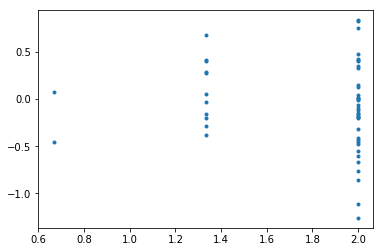

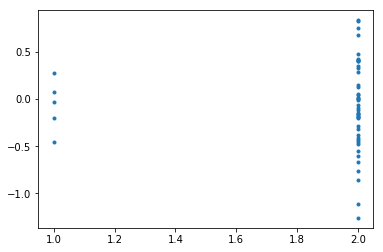

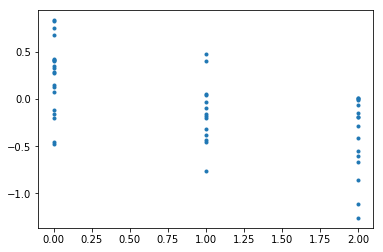

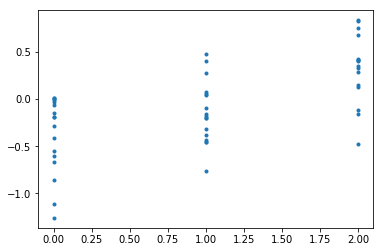

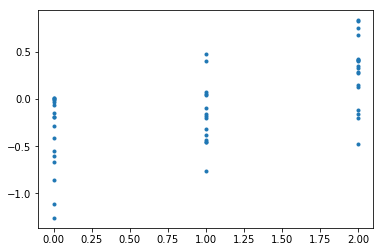

In [15]:
def get_average_improvement(df1, df2):
    ret = []
    for i, j in zip(df1,df2):
        ret.append(np.sum(j) - np.sum(i))
    return ret

improvement = get_average_improvement(bestMSE, bestCOMBO)
np.mean(improvement), np.std(improvement)


fig, ax = plt.subplots()
ax.plot(averageDegree,improvement, '.')
plt.show()


fig, ax = plt.subplots()
ax.plot(targetDegree,improvement, '.')
plt.show()


fig, ax = plt.subplots()
ax.plot(target_inD,improvement, '.')
plt.show()

fig, ax = plt.subplots()
ax.plot(target_outD,improvement, '.')
plt.show()

fig, ax = plt.subplots()
ax.plot(descendants,improvement, '.')
plt.show()

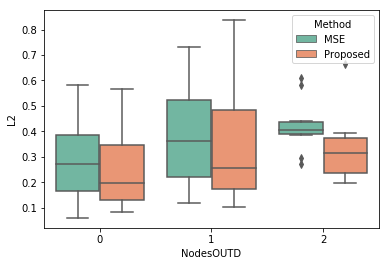

In [8]:
lst = []
for x,y in zip(qbestMSE, descendants):
    lst.append(['MSE', np.mean(x), y])
for x,y in zip(qbestCOMBO, descendants):
    lst.append(['Proposed', np.mean(x), y])


df = pd.DataFrame(lst, columns = ['Method', 'L2', 'NodesOUTD'])
ax = sns.boxplot(data=df, x = 'NodesOUTD', y = 'L2', hue = 'Method', linewidth = 1.5,palette="Set2")

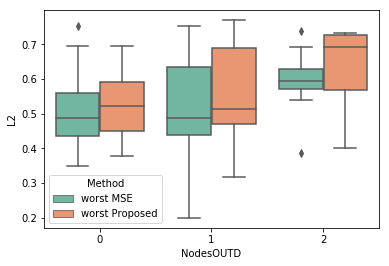

In [7]:
lst = []

for x,y in zip(qworstMSE, descendants):
    lst.append(['worst MSE', np.mean(x), y])
for x,y in zip(qworstCOMBO, descendants):
    lst.append(['worst Proposed', np.mean(x), y])


df = pd.DataFrame(lst, columns = ['Method', 'L2', 'NodesOUTD'])
ax = sns.boxplot(data=df, x = 'NodesOUTD', y = 'L2', hue = 'Method', linewidth = 1.5,palette="Set2")

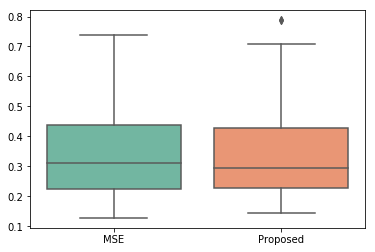

In [6]:
import seaborn as sns
val1 = []
for each in sqbestMSE:
    val1.append(np.mean(each))
val2 = []
for each in sqbestCOMBO:
    val2.append(np.mean(each))

val = []
for x, y in zip(val1, val2):
    val.append([x, y])
df = pd.DataFrame(val, columns = ['MSE', 'Proposed'])
ax = sns.boxplot(data=df, palette="Set2")

In [77]:
np.max(val1), np.max(val2)

(0.6640452593945086, 0.7661277271514675)

array([ 0.0034327 , -0.02559248, -0.13416377, -0.28205571,  0.05900715,
       -0.10903223,  0.2575864 ,  0.09371263, -0.30997229,  0.06285865,
       -0.04113317, -0.28456472, -0.15928204,  0.27316155,  0.56710605,
        0.55499861,  0.15069201,  0.08087676, -0.41550277,  0.06934814,
       -0.37002946,  0.20243078,  0.32295185,  0.21044946, -0.06087649,
       -0.07757568,  0.43419254, -0.16565832, -0.54071483,  0.1115466 ,
        0.00396973,  0.32194001, -0.42890713, -0.04492837, -0.08022409,
        0.30079676, -0.02563958,  0.01746376, -0.27542297,  0.24730838,
        0.22839099, -0.0525733 ,  0.06003491,  0.19578927, -0.20614404,
        0.15330721,  0.06472666, -0.03574063,  0.35898603, -0.42787733])

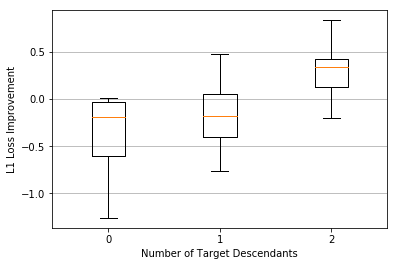

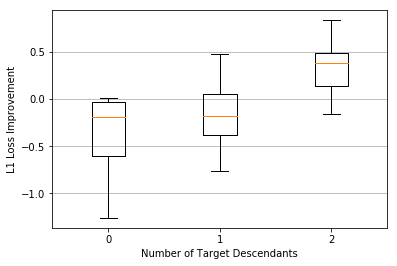

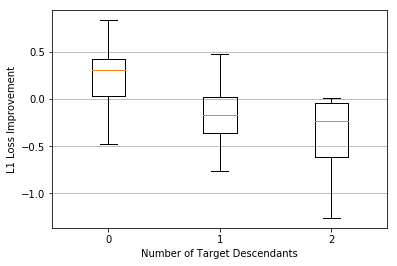

In [16]:
def box_plots(X,Y):
    box = []
    for i in np.unique(X):
        box.append([])
    for x,y in zip(X, Y):
        box[x].append(y)
    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.yaxis.grid(True)
    ax.set_xlabel("Number of Target Descendants")
    ax.set_ylabel("L1 Loss Improvement")
    bp = ax.boxplot(box, showfliers=False, labels = ['0', '1', '2'])
    
box_plots(descendants, improvement)
box_plots(target_outD, improvement)
box_plots(target_inD, improvement)

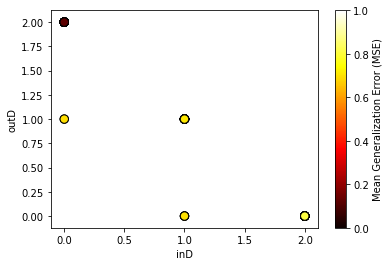

In [45]:
def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', zlab= 'Mean Generalization Error (MSE)', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=70, edgecolor='black', cmap = 'hot')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    #plt.colorbar(cax)
    cbar = plt.colorbar(cax)
    cbar.set_label(zlab)
    plt.show()
    

heat_plot(target_outD, target_inD, normalize(improvement), xlab = 'inD', ylab='outD')

In [ ]:
np.mean(bestMSE), np.mean(bestCOMBO), np.std(bestMSE), np.std(bestCOMBO)

In [ ]:
improvement
fig, ax = plt.subplots()
ax.plot(averageDegree,improvement, '.')
plt.show()

improvement
fig, ax = plt.subplots()
ax.plot(targetDegree,improvement, '.')
plt.show()

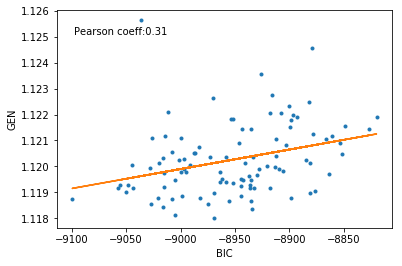

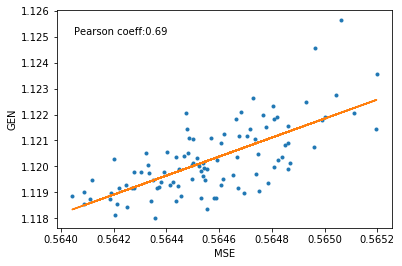

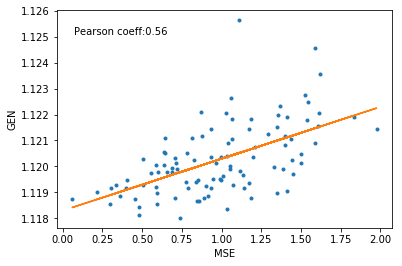

In [11]:
fig, ax = plt.subplots()
b,m = polyfit(proposed,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(proposed,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(proposed,generalization, '.')
plt.plot(proposed, b + m * np.array(proposed), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(metrics,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(metrics,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(metrics,generalization, '.')
plt.plot(metrics, b + m * np.array(metrics), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


total = normalize(metrics) + normalize(proposed)
fig, ax = plt.subplots()
b,m = polyfit(total,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(total,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(total,generalization, '.')
plt.plot(total, b + m * np.array(total), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


In [ ]:
nbest = 10
final = pd.DataFrame(np.stack((metrics, proposed, total, generalization), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
print("MSE = ", np.sum(final.nsmallest(nbest, 'metrics')['generalization']))
print("BIC = ", np.sum(final.nsmallest(nbest, 'proposed')['generalization']))
print("COMB = ",np.sum(final.nsmallest(nbest, 'combined')['generalization']))